In [20]:
import pandas as pd
import numpy as np
import glob, sys, os, time , itertools , warnings , re , json
from tqdm import tqdm
import matplotlib.pyplot as plt
import multiprocessing as mp
from scipy import stats
# from DataProcessing import 
import pickle 
from TempFolder.TempFolder import Temp


import plotly.figure_factory as ff
# importing all necessary libraries 
import chart_studio.plotly as py 
import plotly.graph_objs as go 
import pandas as pd 
  
# some more libraries to plot graph 
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot 
# To establish connection 
init_notebook_mode(connected = True) 


warnings.filterwarnings('ignore')

with open('nogit\\path','r') as f:
    path_to_csv = f.read()
path_to_processed_csv =path_to_csv + 'SC-csv\\'
Temp.set_path(path_to_csv +'SC-temp\\')
path_to_temp_csv = path_to_csv+'SC-working-folder\\'
colummn_names = ['Description'
                 ,'Title State/Type'
                 ,'Location'
                 ,'null'
                 ,'Auction Date'
                 ,'Actual Cash Value'
                 ,'Repair Cost'
                 ,'Odometer'
                 ,'Prim Damage'
                 ,'Sec Damage'
                 ,'Price Sold or Highest Bid']
path_to_makes = glob.glob(path_to_csv+'Cars\\*')
path_to_all_years = list(itertools.chain.from_iterable([glob.glob(path+'\\*') for path in path_to_makes]))


# out_df = Temp.load_obj('out_df_working')

car_demo_joined = Temp.load_obj('car_demo_joined')

Object <out_df_working> loaded from: c:\data\Datasets\SC-temp\
Object <car_demo_joined> loaded from: c:\data\Datasets\SC-temp\


In [ ]:
#fetech counties with no data 
empty_fips = ( pd.merge(car_demo_joined,pd.read_csv(path_to_csv +'Us-zipcodes\\fips_codes.csv',index_col=0)
                .assign(state_fibs = lambda x: x['County'].str.split(', ',expand=True)[1])
                , on='County',how='outer')
                .loc[lambda x: x['make_key'].isna(),['FIPS_y','state_fibs']]
                .drop_duplicates()
                .reset_index(drop=True))

# empty_fips

In [104]:
def geo_plot_county(df: pd.DataFrame,states=None,make=None,model=None,model_year=None,auction_year=None):
    import traceback
    if states:
        df = df.loc[car_demo_joined['State']==states[0]]
        empty_fips_state = empty_fips.loc[empty_fips.state_fibs ==states[0],'FIPS_y'].values.tolist()
    else:
        states = ['USA']
        empty_fips_state = empty_fips['FIPS_y'].values.tolist()
    try:
        filtred = df.loc[(df['Make'] == make)]
        
        if model:
            filtred = filtred.loc[(filtred['Model_short'] == model) ]
        if model_year:
            filtred = filtred.loc[
            (filtred['Model_Year'] == model_year)]
        else:
            model_year = ''
        if auction_year:
            filtred = filtred.loc[(filtred['Auction_Year'] == auction_year)]
        else:
            auction_year = ''
        
        #extract state
        # filtred = (filtred.drop('State',axis=1)
        #             .join(filtred['County'].str.split(', ',expand=True)[1]
        #             .rename('State')))
        
        
        l = filtred.groupby('FIPS')['Price_Sold_or_Highest_Bid'].mean().round().to_dict().items()
        fips , values = map(list , zip(*l) )
        
        #add empty counties
        fips.extend(empty_fips_state)
        values.extend([0] * len(empty_fips_state))
        # import pdb; pdb.set_trace()
        n = np.max(values)
        colorscale=["#f7fbff","#ebf3fb","#deebf7","#d2e3f3","#c6dbef","#b3d2e9","#9ecae1","#85bcdb","#6baed6","#57a0ce","#4292c6","#3082be",      
                     "#2171b5","#1361a9","#08519c","#0b4083","#08306b"
                     ]
        
        # colorscale = [
        #     'rgb(68.0, 1.0, 84.0)',
        #     'rgb(66.0, 64.0, 134.0)',
        #     'rgb(38.0, 130.0, 142.0)',
        #     'rgb(63.0, 188.0, 115.0)',
        #     'rgb(216.0, 226.0, 25.0)',
        #     'rgb(255.0, 130.0, 100.0)',
        #     'rgb(8.,81.,156.)',
        #     'rgb(179,210,233)'
            
        # ]

        endpts = list(np.linspace(1, n, len(colorscale) - 1))
        
        
        fig = ff.create_choropleth(
            fips=fips, values=values,
            binning_endpoints=endpts,
            colorscale=colorscale,
            county_outline={'color': 'black', 'width': 0.5},
            state_outline={'width': 1,'color': 'black',},
            scope=states,
            round_legend_values=True,
            show_state_data=True,
            show_hover=True, centroid_marker={'opacity': 0},
            asp=2.9, title='Price_Sold_or_Highest_Bid by USA County',
            legend_title='Price_Sold_or_Highest_Bid'
        )

        fig.layout.template = None
        fig.layout.xaxis.fixedrange = False 
        fig.layout.yaxis.fixedrange = False 
        fig.show()


        fig.write_image(f"png/bycounty_{auction_year}-{make}-{model}-{model_year}.png")

    except Exception as e:
        print('Error:', e,traceback.format_exc())
        return filtred






# t_stats.ttest_1samp
def ttest(df):
    return df.apply(lambda x: round(stats.ttest_1samp(x.dropna().values,pop_means[x.name])[1],3) )

def signific(v):
    if v < 0.01:
        return '***'
    elif v < 0.05:
        return '**'
    elif v < 0.1:
        return '*'
    else:
        return ''



#value distribution for Prim Damage 
def cond_on(on='Prim_Damage'):
    on_count = (car_demo_joined[on]
    .value_counts()
    .rename('Count')
    .to_frame())

    cond_on_t =(on_count.join(car_demo_joined.groupby(on)[exp_columns]
    .apply(ttest)).dropna()
    .sort_values(by='Count',ascending=False)
    .drop(columns='Count')
    .applymap(signific)
    )


    prim_val_dist = car_demo_joined[on].value_counts()

    #summary statistics conditions on on
    cond_on_primd = car_demo_joined.groupby(on)[exp_columns].agg(['mean']).stack().sort_index(level=1)
    cond_on_primd.index = [i for i, j in cond_on_primd.index]

    

    cond_on_df = (cond_on_primd.join(on_count)
        .sort_values(by='Count',ascending=False)
        .dropna()
        .astype(int)
        [['Count'] + exp_columns]
    )

    #cond_on
    res_df = (on_count.join(pd.concat([ cond_on_df[col].astype(str)+ cond_on_t[col].astype(str)     
                for col in exp_columns] , axis=1)).dropna())
    res_df.index.name =on
    return res_df

In [24]:
model_year = None#2007
auction_year =None# 2018
make = 'TOYOTA'
model = 'CAMRY'
# states = ['CA','AZ','OR','NV']

states = ['CA']
filtred = geo_plot_county(car_demo_joined,states,make,model,model_year,auction_year)

In [ ]:
states = ['IL']
filtred = geo_plot_county(car_demo_joined,states,make,model,model_year,auction_year)

In [28]:
exp_columns = ['Actual_Cash_Value',	'Price_Sold_or_Highest_Bid',	'Repair_Cost',	'Model_Age',	'Odometer_Null'	,'Auction_Year']
pop_means = car_demo_joined[exp_columns].mean()
pop_means

Actual_Cash_Value             11536.592956
Price_Sold_or_Highest_Bid      3394.153648
Repair_Cost                   10611.051583
Model_Age                        10.406675
Odometer_Null                109568.464424
Auction_Year                   2016.544108
dtype: float64

In [79]:

numerical_fields =  ['Actual_Cash_Value_adj'
               ,'Auction_Year'
       , 'Price_Sold_or_Highest_Bid_adj'
       , 'Repair_Cost_adj'
        ,'Odometer_Null'
        ,'Odometer_Replace'
        ,'Model_Age'
        ,'Original_MSRP_mean_adj'
        ,'Unemp_pct_null'
        ,'Unemp_pct_closest'
         ,'Income_adj_null'
        ,'Income_adj_closest'
        ,'CENSUS_null'
        ,'CENSUS_closest'
        ,'GRNDTOT_null'
        ,'GRNDTOT_closest'
        ]

categorical_variables = ['Prim_Damage','Make','Model_short'
]

marching_cols = ['Price_Sold_or_Highest_Bid_adj','Make','Model_short','Model_Age']

In [37]:
#matching estimator
car_demo_joined['Auction_Year'].value_counts().to_frame().reset_index().rename({'index':'year','Auction_Year':'# obs'},axis=1)

,year,# obs
0,2019,234456
1,2018,221186
2,2017,145369
3,2016,145098
4,2015,119510
5,2014,107857
6,2013,79308
7,2012,28465
8,2011,1522
9,2010,301


In [38]:
car_demo_joined.loc[car_demo_joined['Make'] == 'TOYOTA','Model_short'].unique()

array(['FJ40', 'LAND', 'FJ', 'CORONA', 'COROLLA', 'PICK-UP', 'LANDCRUISR',
       'LANDCRUISE', 'HILUX', '4D', 'OTHER', 'CELICA', 'PICK', 'PICKUP',
       'STANDARD', 'SUPRA', 'SR5', 'CRESSIDA', 'DELUXE', 'DOLPHIN',
       'STARLET', 'TERCEL', 'VAN', 'CAMRY', 'MR2', 'FORKLIFT', '4RUNNER',
       'LONG', 'CAB', 'SEABREEZE', 'EXTRA', 'PREVIA', 'SKID', 'PASEO',
       'SHORT', 'TRUCK', 'T100', 'COROLLA/DX', 'CELICA/ST', 'CAMRY/DX',
       'AVALON', 'PREVIA/DX', 'TACOMA', 'RAV4', '4RUNNER/SR', 'RAV', '4',
       'SIENNA', 'SIENNA/CE', 'ECHO', 'SOLARA', 'ARISTO', 'TUNDRA',
       'TUNDRA/SR5', 'HIGHLANDER', 'PRIUS', 'SEQUOIA', '1/2',
       'COROLLA/S/', 'MATRIX', 'MATRIX/XR', 'CORROLA', 'COROLLA/MA',
       'CORROLLA', '2DR', 'XB', 'HIGLANDER', 'SIENNA/LE', 'YARIS',
       'CAMRY-LE', 'AV', 'ALL', 'COROLL', 'CAM', 'SCION', 'VENZA',
       'COROLLA/LE', 'CAMRY/SE/L', 'COR', 'CAMRY/LE/X', 'AVALON/LIM',
       'FR-S', 'HIGHLNDER', 'MIRAI', 'IA', '86', 'C-HR'], dtype=object)

[Text(0, 0.5, 'Frequency'),
 Text(0.5, 0, 'Population, M'),
 Text(0.5, 1.0, 'Population Distribution')]

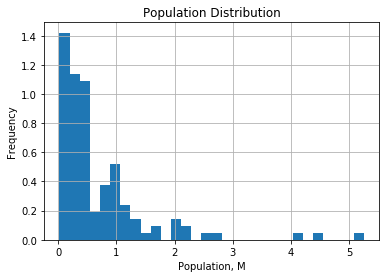

In [58]:
subsample = car_demo_joined.loc[car_demo_joined['Auction_Year'] == 2018]

ax =( car_demo_joined.drop_duplicates(subset=['County'])['CENSUS_closest'].dropna() / 1e6).hist(bins=30,normed=True)

ax.set(title = 'Population Distribution', xlabel='Population, M', ylabel='Frequency')

In [66]:
#find match candidates 

model_name ='_10p' #_20p_500k1m
match_null = Temp.load_obj('expected_match_indexed'+model_name)
match_e = match_null.loc[match_null.map(lambda x: len(x)>0)]
print('% of records that matched: ', 100*len(match_e) / len(match_null),'%\n',match_e.head()
,'# of recoreds that matched:', match_e.shape
)





#ex pet of c,match_null.shape[0]ted match

expected_match = Temp.load_obj('expected_match'+model_name)
#calculate difference 
expected_match_diff = expected_match.diff(axis=1).dropna(axis=1)#.abs()

#calc statistics
print('Non-truncated:'
    ,expected_match_diff.agg(['mean','std']) ,'\nt-test p value:', round(stats.ttest_1samp(expected_match_diff.values.reshape(-1,),0)[1],3),'\n'
	)
    

expected_match_diff_trunc =expected_match_diff.loc[(expected_match_diff.actual_value_small_city > expected_match_diff.actual_value_small_city.quantile(0.01)) & (expected_match_diff.actual_value_small_city <expected_match_diff.actual_value_small_city.quantile(0.99))]

    
print('1th and 99th:'
    ,expected_match_diff_trunc.agg(['mean','std']) ,'\nt-test p value:', round(stats.ttest_1samp(expected_match_diff_trunc.values.reshape(-1,),0)[1],3),'\n',expected_match.head())

Object <expected_match_indexed_10p> loaded from: c:\data\Datasets\SC-temp\
% of records that matched:  9.805485420521562 %
 576193    [128555]
370474    [384010]
468937    [384010]
427613    [128500]
427677    [190502]
Name: match, dtype: object # of recoreds that matched: (43030,)
Object <expected_match_10p> loaded from: c:\data\Datasets\SC-temp\
Non-truncated:       actual_value_small_city
mean              -265.344772
std               1501.915648 
t-test p value: 0.0 

1th and 99th:       actual_value_small_city
mean              -260.589592
std                926.044551 
t-test p value: 0.0 
         expected_value_big_city  actual_value_small_city
576193                   2400.0                   4050.0
370474                  11600.0                  11900.0
468937                  11600.0                   4600.0
427613                   3750.0                   3850.0
427677                   3400.0                   2000.0


In [57]:
#find match mahalanobis 
mahalanobis_match = Temp.load_obj('mahalanobis_match'+model_name)

#calculate difference between small and the large cities
mahalanobis_match_diff = mahalanobis_match.diff(axis=1).dropna(axis=1)#.abs()

#calc statistics
print(mahalanobis_match_diff.agg(['mean','std']) ,'\nt-test p value:'
, round(stats.ttest_1samp(mahalanobis_match_diff.values.reshape(-1,),0)[1],3)

)

mahalanobis_match_diff_trun= mahalanobis_match_diff.loc[(mahalanobis_match_diff.actual_value_small_city > mahalanobis_match_diff.actual_value_small_city.quantile(0.01)) & (mahalanobis_match_diff.actual_value_small_city <mahalanobis_match_diff.actual_value_small_city.quantile(0.99))]

print('\nTruncated: ',
mahalanobis_match_diff_trun.agg(['mean','std']) ,'\nt-test p value:', round(stats.ttest_1samp(mahalanobis_match_diff_trun.values.reshape(-1,),0)[1],3)
,'\n',mahalanobis_match.head()
)

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\data\\Datasets\\SC-temp\\mahalanobis_match_10p_1m1m.pickl'

In [44]:
# #define the matching model (logistic regression)
# from pymatch.Matcher import Matcher
# from tqdm import tqdm
# match_acc = dict()
# #for each group (which is defined as low/ high population county) find a match based on the following variables:
# #Make (exacte), Model(exact) , Prim Damage (exact), Actual_Cash_value/Odometer/MSRP (within 10%).
# for name , subsample_uniqe in tqdm(subsample.groupby(['Make','Model_short'#,'Model_Age'
#                                                 ])):
#     try:
#         print(f'\nmatchign {name}...')
#         test = subsample_uniqe.loc[subsample['is_big_city'] == 0]
#         control = subsample_uniqe.loc[subsample['is_big_city'] == 1]
#         m = Matcher(test, control, yvar="is_big_city", exclude=['CENSUS_closest','Make','Model_short','Model_Age'])
#         m.fit_scores(balance=True, nmodels=100)
#         match_acc[name] =np.mean(m.model_accuracy)
#         # m.predict_scores()
#         # m.plot_scores()
#         # break
#     except: pass
# match_acc_df = pd.DataFrame.from_dict(match_acc,orient='index').rename({0:'matching_accuracy'},axis=1)

age Accuracy: 51.91%

matchign ('MERCEDES-BENZ', 'E-CLASS')...
Formula:
is_big_city ~ Price_Sold_or_Highest_Bid_adj
n majority: 1
n minority: 0
Fitting Models on Balanced Samples: 1\100
matchign ('MERCEDES-BENZ', 'GLA')...
Formula:
is_big_city ~ Price_Sold_or_Highest_Bid_adj
n majority: 24
n minority: 24
Fitting Models on Balanced Samples: 100\100
Average Accuracy: 50.0%

matchign ('MERCEDES-BENZ', 'GLC')...
Formula:
is_big_city ~ Price_Sold_or_Highest_Bid_adj
n majority: 24
n minority: 14
Fitting Models on Balanced Samples: 100\100
Average Accuracy: 49.79%

matchign ('MERCEDES-BENZ', 'GLE')...
Formula:
is_big_city ~ Price_Sold_or_Highest_Bid_adj
n majority: 27
n minority: 16
Fitting Models on Balanced Samples: 100\100
Average Accuracy: 53.44%

matchign ('MERCEDES-BENZ', 'GLK')...
Formula:
is_big_city ~ Price_Sold_or_Highest_Bid_adj
n majority: 83
n minority: 70
Fitting Models on Balanced Samples: 100\100
Average Accuracy: 55.49%

matchign ('MERCEDES-BENZ', 'GLS')...
Formula:
is_big_ci

,matching_accuracy
count,304.000000
mean,0.566000
std,0.064668
min,0.443214
25%,0.521991
50%,0.550458
75%,0.594550
max,0.882500


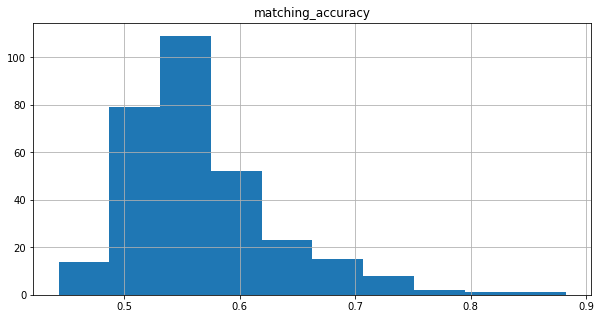

In [47]:
match_acc_df.hist()

match_acc_df.describe()

In [18]:
car_demo_joined.groupby(car_demo_joined.Repair_Cost.isna())['Price_Sold_or_Highest_Bid'].mean()

Repair_Cost
False    2980.579718
True     3569.552899
Name: Price_Sold_or_Highest_Bid, dtype: float64

In [59]:
'''
TABLES
'''

In [87]:
#prepare for tables
cols = ['Actual_Cash_Value_adj'
        ,'Price_Sold_or_Highest_Bid_adj'
        ,'Prim_Damage'
        ,'Repair_Cost_adj'
        ,'Model_Year'
        ,'Auction_Year'
        # ,'Odometer_Null'
        ,'Odometer_Replace'
        # ,'Model_Age'
        ,'Make'
        ,'Model_short'
        ,'County'
        ,'Original_MSRP_mean_adj'
        # ,'Unemp_pct_null'
        ,'Unemp_pct_closest'
        ,'CENSUS_closest'
        # ,'CENSUS_null'
        # ,'Income_adj_null'
        ,'Income_adj_closest'
        # ,'GRNDTOT_null'
        ,'GRNDTOT_closest'
        ]




cars = car_demo_joined[cols]

In [69]:
def save_table(df,name):
    with open(f'csv/tables/{name}.tex','w') as f:
        f.write(df.to_latex())

In [71]:
'''
Table 1 
Missing values
'''
from DataProcessing.DataStats import get_df_stats
table1_mv = get_df_stats(cars).reset_index(drop=True).drop(columns=['dtype']).round(2)

save_table(table1_mv,'Unique values')

table1_mv

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category
0,GRNDTOT_null,494,75.68,75.68
1,Repair_Cost_adj,172968,63.71,63.71
2,Original_MSRP_mean_adj,2791,52.59,52.59
3,Unemp_pct_null,112,41.09,41.09
4,GRNDTOT_closest,505,28.30,28.30
5,CENSUS_closest,929,25.09,25.09
6,Unemp_pct_closest,112,25.09,25.09
7,Actual_Cash_Value_adj,208063,21.46,21.46
8,Price_Sold_or_Highest_Bid_adj,4235,0.00,0.64
9,Prim_Damage,28,0.00,41.67


In [73]:
'''
Table 2 
Summary Statistics - Full
'''

table1_summary = cars.describe(percentiles =[.01,.25, .5, .75,.99]).T
save_table(table1_summary,'Summary Statistics')
table1_summary

,count,mean,std,min,1%,25%,50%,75%,99%,max
Actual_Cash_Value_adj,850668.0,1.023250e+04,1.039930e+04,85.29,870.84,4280.83,7455.90,12779.36,4.733805e+04,908540.17
Price_Sold_or_Highest_Bid_adj,1083072.0,3.004877e+03,5.384161e+03,0.00,181.71,746.31,1591.26,3386.68,2.098193e+04,1736757.64
Repair_Cost_adj,393017.0,9.437105e+03,1.813730e+04,0.01,900.26,5374.40,8184.47,11709.27,2.976108e+04,9694004.96
Model_Year,1083072.0,2.007139e+03,6.461758e+00,1920.00,1988.00,2003.00,2007.00,2012.00,2.018000e+03,2019.00
Original_MSRP_mean_adj,513435.0,3.095493e+04,1.385519e+04,11561.52,13403.57,23206.95,26891.28,36128.04,7.608258e+04,489706.62
Unemp_pct_null,638087.0,5.143472e+00,1.627076e+00,2.20,2.50,4.00,4.80,5.90,1.040000e+01,16.70
Unemp_pct_closest,811322.0,4.877080e+00,1.588481e+00,2.20,2.50,3.80,4.50,5.50,1.020000e+01,16.70
CENSUS_closest,811318.0,1.300488e+06,1.278870e+06,17631.00,40571.00,379803.00,892697.00,1540975.00,5.204502e+06,5257481.00
GRNDTOT_null,263443.0,3.629494e+04,3.979614e+04,0.00,0.00,9036.00,21952.00,47306.00,1.670020e+05,200372.00
GRNDTOT_closest,776603.0,3.436253e+04,3.653485e+04,0.00,0.00,8908.00,22199.00,44037.00,1.500050e+05,200372.00


In [105]:
'''
Table 4 - Conditioned on prim damage

'''

on_Prim_Damage =cond_on(on='Prim_Damage')
save_table(on_Prim_Damage,'Conditioned on Prim Damage')
on_Prim_Damage

,Count,Actual_Cash_Value,Price_Sold_or_Highest_Bid,Repair_Cost,Model_Age,Odometer_Null,Auction_Year
Prim_Damage,,,,,,,
front end,451339,12302***,3192***,10800***,8***,93178***,2016***
rear end,108003,10697***,3129***,9514***,9***,103443***,2016***
mechanical,107338,5841***,1835***,6828***,13***,158948***,2016***
minor dent/scratches,95253,6500***,2766***,5631***,14***,160880***,2017***
side,95152,11493,3392,10078***,9***,100556***,2016***
normal wear,53217,10579***,4667***,3035***,14***,149287***,2015***
all over,33615,14596***,3477***,13843***,8***,86717***,2016***
water/flood,33168,19478***,7096***,11611***,7***,76104***,2016***
minor dents/scratche,25612,9497***,3884***,3161***,13***,153820***,2013***


In [106]:
'''
Table 5 - Conditioned on Make

'''

table_onmake = cond_on(on='Make')

save_table(table_onmake,'Conditioned on make')
table_onmake

,Count,Actual_Cash_Value,Price_Sold_or_Highest_Bid,Repair_Cost,Model_Age,Odometer_Null,Auction_Year
Make,,,,,,,
TOYOTA,146806,10139***,3433***,10430***,10***,123841***,2016***
HONDA,112347,9618***,2565***,10150**,10***,118591***,2016***
FORD,101645,9898***,2461***,9645***,10,109655,2016***
NISSAN,93894,9857***,2515***,10232***,8***,101458***,2016***
CHEVROLET,79327,11202***,2935***,10432***,10***,99595***,2016***
HYUNDAI,46118,9882***,2616***,10233***,7***,92164***,2016***
DODGE,43490,10205***,2614***,9863***,9***,111271***,2016***
BMW,40917,17552***,5916***,13206***,10***,102509***,2016***
MERCEDES-BENZ,40358,21163***,7656***,14449***,11***,97333***,2016***


In [107]:
'''
Table 6 - Conditioned on Auction Year
'''

table_onauctyear = cond_on(on='Auction_Year')
save_table(table_onauctyear,'Conditioned on auction Year')

table_onauctyear

,Count,Actual_Cash_Value,Price_Sold_or_Highest_Bid,Repair_Cost,Model_Age,Odometer_Null,Auction_Year
Auction_Year,,,,,,,
2019,234456,10918***,2982***,10238***,10***,111129***,2019***
2018,221186,10111***,3001***,10330***,10***,109624,2018***
2017,145369,12024***,3339***,10881***,9***,98816***,2017***
2016,145098,11700***,3054***,11101***,9***,104582***,2016***
2015,119510,11929***,3396,10657,9***,108348***,2015***
2014,107857,11944***,3663***,10100***,10***,117930***,2014***
2013,79308,14033***,4723***,10256***,10***,120793***,2013***
2012,28465,13681***,5485***,9556***,10***,121760***,2012***
2011,1522,17293***,6088***,30125,8***,87501***,2011***


In [90]:
'''
Table 7 - Correlation Analysis
'''

corr_table = cars[cols].corr().round(3)

save_table(corr_table,'correlation')

corr_table

,Actual_Cash_Value_adj,Price_Sold_or_Highest_Bid_adj,Repair_Cost_adj,Model_Year,Auction_Year,Odometer_Replace,Original_MSRP_mean_adj,Unemp_pct_closest,CENSUS_closest,Income_adj_closest,GRNDTOT_closest
Actual_Cash_Value_adj,1.000,0.770,0.224,0.379,-0.107,-0.280,0.458,0.065,0.109,0.012,0.126
Price_Sold_or_Highest_Bid_adj,0.770,1.000,0.138,0.210,-0.101,-0.185,0.382,0.065,0.106,0.007,0.119
Repair_Cost_adj,0.224,0.138,1.000,0.159,-0.022,-0.076,0.215,0.011,0.007,0.007,0.012
Model_Year,0.379,0.210,0.159,1.000,0.292,-0.315,-0.143,-0.219,0.085,0.038,0.061
Auction_Year,-0.107,-0.101,-0.022,0.292,1.000,-0.004,-0.028,-0.692,0.012,0.100,-0.034
Odometer_Replace,-0.280,-0.185,-0.076,-0.315,-0.004,1.000,0.017,-0.005,-0.036,-0.024,-0.025
Original_MSRP_mean_adj,0.458,0.382,0.215,-0.143,-0.028,0.017,1.000,0.016,0.055,0.025,0.054
Unemp_pct_closest,0.065,0.065,0.011,-0.219,-0.692,-0.005,0.016,1.000,0.016,-0.276,0.042
CENSUS_closest,0.109,0.106,0.007,0.085,0.012,-0.036,0.055,0.016,1.000,0.040,0.760
Income_adj_closest,0.012,0.007,0.007,0.038,0.100,-0.024,0.025,-0.276,0.040,1.000,0.045


,Market Size,Cars Sold
Auction_Year,,
2010,1.695600,301
2011,8.983675,1522
2012,148.304731,28465
2013,350.647100,79308
2014,363.943224,107857
2015,373.488342,119510
2016,402.647193,145098
2017,431.840616,145369
2018,576.489736,221186


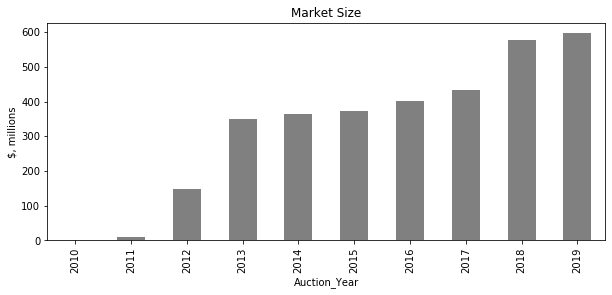

In [112]:
'''
Table 8 - Market Size
'''

#market size

market_size = (cars.reset_index()
                .groupby(cars['Auction_Year'])
                .agg({'Price_Sold_or_Highest_Bid_adj' :'sum','index':'count'})
                .rename(columns={'Price_Sold_or_Highest_Bid_adj':'Market Size',
                'index':'Cars Sold'})
                .astype(int))



save_table(market_size,'market size')

plt.figure(figsize=(10,4))

market_size['Market Size'] /= 1e6
ax = market_size['Market Size'].plot.bar(color ='grey')
ax.set(title='Market Size', ylabel='$, millions')
plt.savefig('png/marketsize.png')
market_size